# Lab 4: Linear Classifiers
Machine Learning 2020/2021 <br>
Ruben Wiersma and Gosia Migut

Revised by Yorick de Vries

**WHAT** This nonmandatory lab session consists of several programming exercises and questions to help provide insight into linear classifiers. 

**WHY** The exercises are meant to familiarize yourself with the basic concepts of linear classifiers and to get familiar with a benchmark machine learning dataset: the MNIST handwritten digit dataset.

**HOW** Follow the exercises in this notebook either on your own or with a fellow student. There is quite a bit of theory and explanation in these notebooks. If you want to skip right to questions and exercises, find the $\rightarrow$ symbol. Use [Mattermost][1] to discuss questions with your peers. For additional questions and feedback please consult the TA's during the lab session. 

[1]: https://mattermost.ewi.tudelft.nl/

$\newcommand{\q}[1]{\rightarrow \textbf{Question #1}}$
$\newcommand{\ex}[1]{\rightarrow \textbf{Exercise #1}}$
$$
\newcommand{\ls}[1]{{}^{(#1)}}
\renewcommand{\v}[1]{\boldsymbol{#1}}
\renewcommand{\T}{{}^{\top}}
\newcommand{\matvec}[1]{\begin{pmatrix}#1\end{pmatrix}}
$$

### Classifying handwritten digits with logistic regression

In postal offices mail items need to be sorted according to their zip codes. Many of these zip codes are handwritten and manual sorting is a cumbersome task. In this exercise we will look into how we can automatically classify such hand written digits. In this assignment we will use a common machine learning benchmark dataset: the MNIST dataset.

This dataset was originally created from digits written by postal office workers and published by the National Institute of Standards and Technology (NIST) as the NIST dataset. Hereafter, it was modified by adding digits written by high school students to become the Modified NIST dataset (MNIST). MNIST consists of 60,000 training objects and 10,000 testing objects, where each object is represented by a $28\times28$ grayscale image of a digit ($0 - 9$). In this exercise we will use downsampled $8 \times 8$ pixel versions of these images.

### Goal

- We have $n$ training images $x^{(1)}, \ldots, x^{(n)}$. Each $x^{(i)}$ is a $64 \times 1$ vector, representing the grayscale values for each pixel in the $8 \times 8$ image.
- Each image is associated with a discrete label $y^{(i)} \in \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}$.
- We want to derive a hypothesis function that can predict the label of any new image $x$.

In this lab session, we will find out the following:
1. How to define a hypothesis function $h_{\theta}(x) \approx y$
2. How to measure how 'good' a classifier is using the log likelihood
3. How to find a $\theta$ (the weight vector) that maximizes this log likelihood

And finally, we will apply this knowledge to classify images in the MNIST dataset.

## 0. Dependencies

$\rightarrow$ Make sure that you have installed `scipy` and `scikit-learn` in your conda environment. If you're unsure that you have, run `conda list` in your terminal to check which packages are installed and use `conda install [package name]` to install new packages.

In [1]:
import scipy
import sklearn
import numpy as np
import matplotlib.pyplot as plt

## 1. A look at the MNIST database
Scikit-learn, a common machine learning package for Python, has a small version of the MNIST dataset built-in. The dataset that we use contains images of hand-written digits that are $8 \times 8$ pixels (instead of the original $28 \times 28$ pixels), which makes the dataset easier to work with.

To get a grasp of what objects in the dataset look like, an example of one of every digit is visualized with the code below.

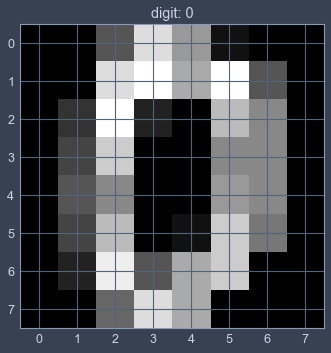

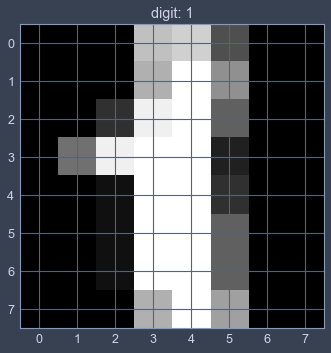

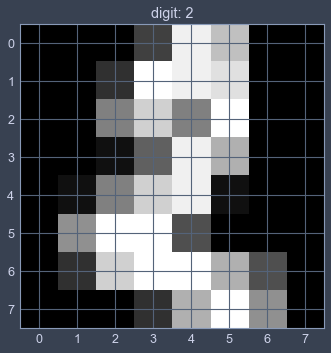

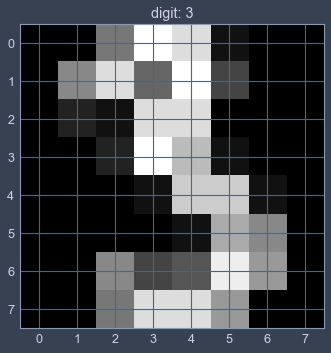

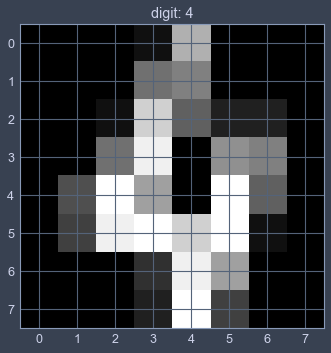

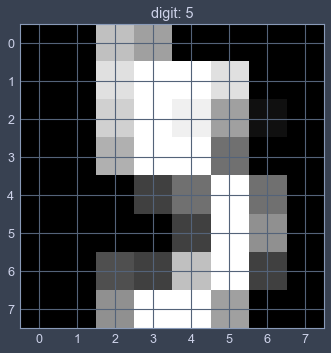

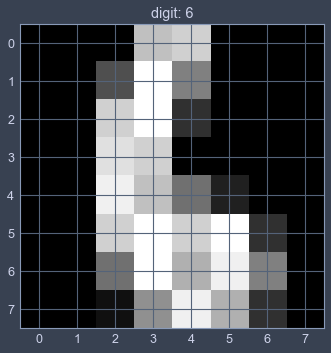

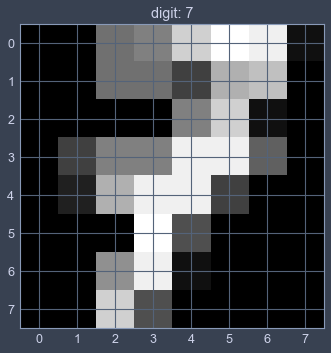

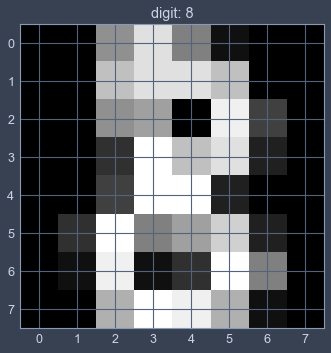

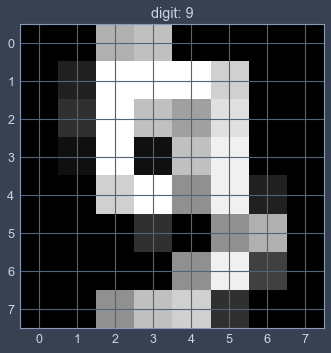

In [2]:
from sklearn import datasets

# Load the digits with 10 classes (digits 0 - 9)
all_digits = datasets.load_digits(n_class=10)
all_digits_images = all_digits.images
all_digits_labels = all_digits.target

'''
all_digits_images is a numpy array where:
- the first index is the index of individual images
- the second index corresponds to the row of the pixel
- the third index corresponds to the column of the pixel
i.e.: all_digits_images[image_index,row,column]
the values of the pixels are values between 0 (black) and 16 (white)
'''
from jupyterthemes import jtplot
jtplot.style(theme = "oceans16")

for i in range(10):
    digit_image = all_digits_images[i,:,:]
    plt.figure()
    plt.gray()
    plt.title("digit: " + str(all_digits_labels[i]))
    plt.imshow(digit_image)

### Binary classification
Although we have have 10 different classes, we will first focus on the binary classification of the digits 0 and 1.
These digits are loaded with the code below and several of them are plotted.

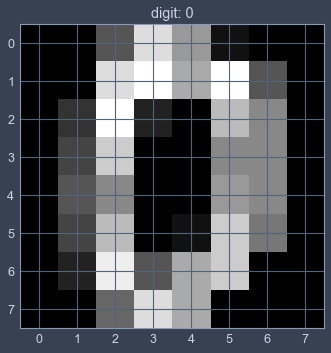

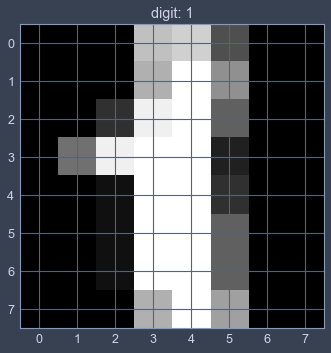

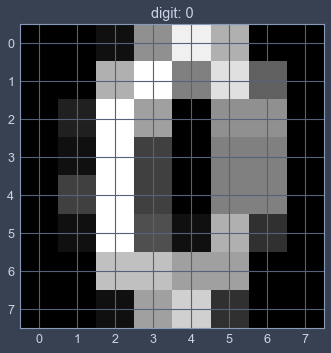

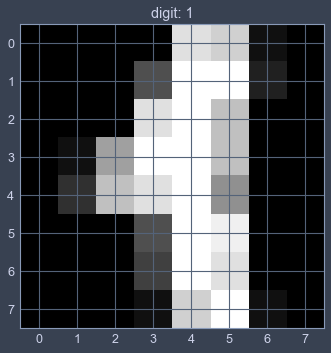

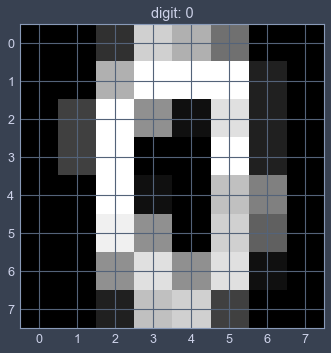

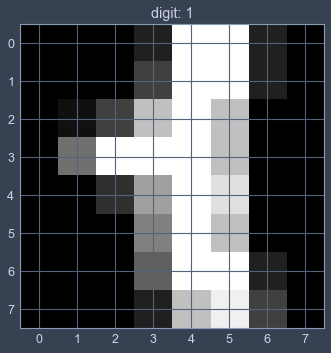

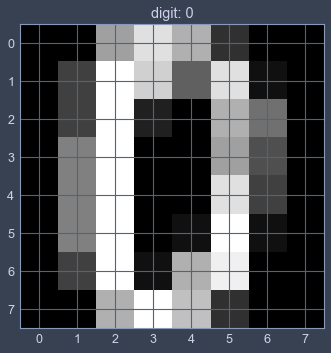

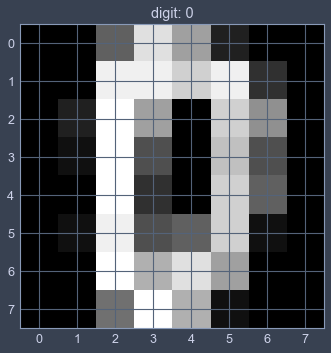

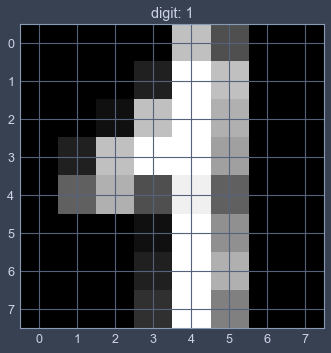

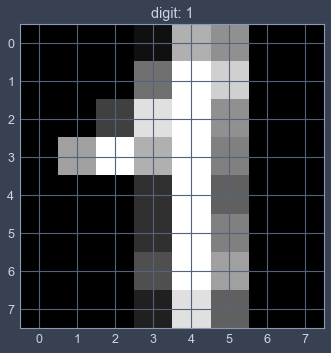

In [3]:
# Load the digits with 2 classes (0 and 1)
binary_digits = datasets.load_digits(n_class=2)
binary_digits_images = binary_digits.images
binary_digits_labels = binary_digits.target

for i in range(10):
    digit_image = binary_digits_images[i,:,:]
    plt.figure()
    plt.gray()
    plt.title("digit: " + str(binary_digits_labels[i]))
    plt.imshow(digit_image)

## 2. Basic Features
We start with calculating a few basic features of the images, to be used by our classifier. Only having a few features helps us in visualizing what the classifier is doing. Once we can classifiy based on simple features, we will extend our classifier to include more features.

We start with two basic features: <span style="color:#228b22">crude measures of the length and width of the digit</span>. For widths, we measure this by taking the maximum values for every column and then taking the average of these values. For the length we take the maximum value of each row and then we average over these values. Other, more precise ways to measure the width and length of the digit are possible, but we will use this simple definition for now.

$\ex{2.1}$ Implement the calculation of the length and width features in the code below.

In [4]:
# width: average of the columnwise max values
widths = np.zeros(len(binary_digits_images))
# START ANSWER
for i in range(len(binary_digits_images)):
    widths[i] = np.sum(np.max(binary_digits_images[i,:,:], axis=0))/binary_digits_images.shape[2]
# END ANSWER

# length: average of the row max values
lengths = np.zeros(len(binary_digits_images))
# START ANSWER
for i in range(len(binary_digits_images)):
    lengths[i] = np.sum(np.max(binary_digits_images[i,:,:], axis=-1))/binary_digits_images.shape[2]
# END ANSWER
# END ANSWER

assert (widths[:5] == np.array([8.5, 8.0, 9.25, 8.125, 9.5])).all()
assert (lengths[:5] == np.array([12.875, 15.625, 15.0, 15.75, 14.875])).all()

Let's combine these two arrays into one numpy array called `binary_digits_features`

In [5]:
binary_digits_features = np.vstack((widths, lengths)).T
print(binary_digits_features[:10])

[[ 8.5   12.875]
 [ 8.    15.625]
 [ 9.25  15.   ]
 [ 8.125 15.75 ]
 [ 9.5   14.875]
 [ 9.375 15.875]
 [ 9.375 15.75 ]
 [ 9.    15.5  ]
 [ 7.75  15.375]
 [ 8.625 15.125]]


Plot the features in a scatterplot and see what the data looks like:

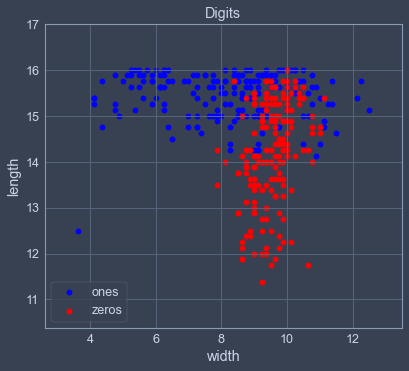

In [6]:
def plot_scatter(features, labels, db_x = None, db_y = None):
    widths = features[:,0]
    lengths = features[:,1]
    
    # separate the 2 classes
    widths_0 = widths[labels == 0]
    lengths_0 = lengths[labels == 0]
    widths_1 = widths[labels == 1]
    lengths_1 = lengths[labels == 1]

    # Plot
    plt.scatter(widths_1, lengths_1, c='blue', label='ones')
    plt.scatter(widths_0, lengths_0, c='red', label='zeros')
    
    # Extra code to plot the decision boundary
    # You won't be using this right away
    if not(db_x is None or db_y is None):
        plt.plot(db_x, db_y, label = "Decision_Boundary")

    plt.title('Digits')
    plt.xlabel('width')
    plt.ylabel('length')
    plt.xlim((widths.min()-1, widths.max()+1))
    plt.ylim((lengths.min()-1, lengths.max()+1))
    plt.legend(loc=3)
    plt.show()

plot_scatter(binary_digits_features, binary_digits_labels)

## 3. Linear Classification

We want to construct a classifier which, given digit features, decides whether the digit is a $1$ or $0$. To achieve this, we want to find a "decision function" $f(x)$, that, given an object represented by the vector $x$, returns a high value if the object belong to class $1$ and a small value if it belong to class $0$. To decide which class to assign an object to, we can set a threshold to decide when the decision value is large enough. A linear classifier makes a particular choice for what the decision function $f(x)$ can look like: the function is a linear combination of the values of the features. For a one-dimensional dataset the decision takes the following form:

- If $\theta_1 * x > threshold$ classify as $1$ (else as not $1$).

Here $\theta_1$ and $threshold$ are the two parameters which need to be tuned for the classifier to work properly.

In case of the two features we have now, this classifier will look like:

- If $\theta_1 * weight + \theta_2 * length > threshold$ classify as $1$.

And in general, we can write this down in the concise form of a vector multiplication:

- If $\theta\T x > threshold$ classify as $1$.

Here the weights are contained in a $\theta$ vector with the same length as the number of features of the data.

The classifier takes the dot product of these vectors and checks whether the obtained value exceeds the $threshold$ value for a positive classification.

$\q{3.1}$ Write out the dot-product between $\theta$ and $x$ if both are a vector of size $4$. Can you see that the dot product is a simple way of writing a linear combination of $x$'s elements?

The threshold is also a parameter which we should train, so it's handy to have it at the same side of the equation as $\theta\T x$. We can rewrite our classification rule as follows:

$\theta\T x > threshold$

$\theta\T x - threshold > 0$

Furthermore, we can replace the notion of $-threshold$ with $bias$, which is the value which needs to be added when the threshold is set to 0. So our classification rule is now:

If $\theta\T x + bias > 0$ classify as $1$.

### Logistic function
For our linear classifier, $\theta\T x + bias > 0$, we can visually try out some values for the parameters to see what seems like a reasonable decision boundary. When we have more features this becomes hard to do manually, and it is unclear whether this is an "optimal" solution. So, how can we automate this process?

To do this we first need to define how to measure the quality of a solution $\theta$. One obvious measure is the number of mistakes made by the classifier: the number of objects in the training set that were misclassified. It turns out, however, that it is difficult to find the parameters that minimize this quantity directly. In addition, we may not only care about the number of mistakes, but also other properties of our classifier, such giving an accurate estimate of the uncertainty in its decisions.

Instead of finding the $\theta$ that minimizes the classification error, we are going to construct a linear classifier that returns probabilities of objects belonging to the different classes and find the $\theta$ that maximizes how well these probabilities reflect the data we have observed. 

To do this, we first have to convert the values of our decision function  $\theta\T x + bias$, into values between $0$ and $1$. These values will reflect the probability of the object to belong to class $1$. For this conversion, we will use the logistic function:

$$\sigma(\v\theta\T x + bias) = \frac{1}{1 + e^{-(\v\theta\T x + bias)}}$$

Notice that $\sigma(z)$ converges to $1$ as $z \rightarrow \infty$, and $\sigma(z)$ converges to $0$ as $z \rightarrow - \infty$. So, $\sigma(z)$, is always bounded between $0$ and $1$, which is convenient for modelling a probability.

Another useful property of the derivative of the logistic function that we will use later on is the following:

$$\sigma'(z) = \sigma(z)(1 - \sigma(z))$$

Plot the logistic function with the code below.

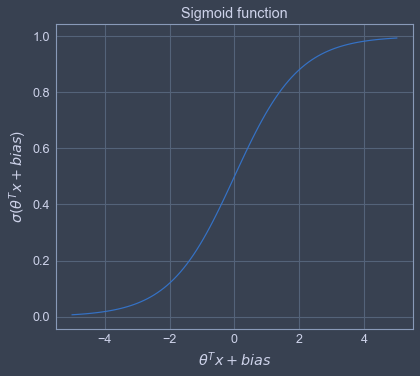

In [7]:
z = np.linspace(-5, 5, 100)
sigmoid = 1 / (1 + np.exp(-z))
plt.title('Sigmoid function')
plt.xlabel(r'$\theta^T x + bias$')
plt.ylabel(r'$\sigma(\theta^T x + bias$)')
plt.plot(z, sigmoid)

### So what does this actually do?
$\q{3.2}$ Have another look at the hypothesis function ($h$) and answer the questions below:

$$h_{\theta;bias}(x) = \frac{1}{1 + e^{-(\theta\T x + bias)}}$$

- What happens to $h_{\theta;bias}(x)$ when $\theta\T x + bias$ is very negative?
- What happens to $h_{\theta;bias}(x)$ when $\theta\T x + bias$ is 0?
- What happens to $h_{\theta;bias}(x)$when $\theta\T x + bias$ is very positive?

The logistic function helps us to convert the function ($\theta\T x + bias$) with range $(-\infty,+\infty)$ to a function with range $(0,1)$. The new formula has a decision boundary which is set at $0.5$. These values are much better usuable as it is now possible to actually calculate the error of the predicted values compared to the desired values.

### Probabillities

We now have a hypothesis function ($h$) to predict the probability that the given digit belongs to class $1$. If the probability is high (above 0.5), we can conclude the digit is a $1$, if it is low, the digit is likely a $0$.

Thus, we have:

$$
P(Y = 1 | x; \theta, bias) = h_{\theta,bias}(x)\\
P(Y = 0 | x; \theta, bias) = 1 - h_{\theta,bias}(x)
$$

In the formulas, $x; \theta,bias$ denotes the data point $x$ in a model with parameters $\theta$ and $bias$.

$\ex{3.1}$ Let's now try to fit the probability of the observed class labels using the logistic function. We will use only the $width$ feature (on the x-axis) for this. Try to find parameters such that the logistic function is a good approximation of the probability that an object belongs to class 1, $P(Y=1)$, for all inputs.

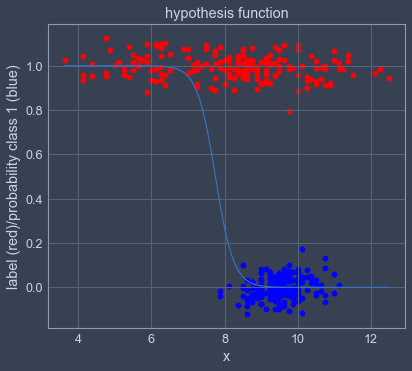

In [8]:
def plot_hypothesis(features, labels, theta, bias):
    widths = features[:,0]
    # some noise is added to better visualize the labels of the datapoints
    labels_noise = labels + np.random.normal(0, .05, labels.shape)

#     plt.scatter(widths, labels_noise, c='red')
    widths_0 = widths[np.where(labels == 0)]
    widths_1 = widths[np.where(labels == 1)]
    plt.scatter(widths_0, labels_noise[np.where(labels_noise < 0.5)], c='blue')
    plt.scatter(widths_1, labels_noise[np.where(labels_noise >= 0.5)], c='red')

    x = np.linspace(np.min(widths), np.max(widths), 100)
    sigmoid_1D = 1 / (1 + np.exp(-(theta*x + bias)))
    plt.title('hypothesis function')
    plt.xlabel('x')
    plt.ylabel('label (red)/probability class 1 (blue)')
    plt.plot(x, sigmoid_1D)
    plt.show()

# try to find proper values for theta and bias
# such that the sigmoid properly goes through both the datapoints with label 0 and 1
theta = -4
bias = 31
# START ANSWER
# END ANSWER

plot_hypothesis(binary_digits_features, binary_digits_labels, theta, bias)

You can see that we can find proper values for $\theta$ and $bias$ such that we can fit a sigmoid function through the data and predict the labels. Later we will try to obtain these values automatically through training.

### Getting rid of bias

Working with $\theta$ and $bias$ separately makes things quite complicated, especially when we are trying to optimize these values. We will therefore incorporate $bias$ as the last element in the $\theta$ vector: $\theta^\prime$

$$\theta^\prime = [\theta_1, \theta_2, ... \theta_n, bias]\T$$

To be able to use this new $\theta^\prime$, we should add an extra feature of $1.0$ to every feature vector:

$$x^\prime = [x_1, x_2, ... x_n, 1.0]\T$$

$\q{3.3}$ Check that the dot-product between $\theta\T x + bias$ equals $\theta^\prime\T x^\prime$

From now on we will only refer to the adjusted $\theta^\prime$ and $x^\prime$ (also when mentioning $\theta$ and $x$).

In [9]:
# This function adds an extra 1.0 to every feature vector
def add_one_features(data):
    return np.vstack((data.T, np.ones(len(data)))).T

binary_digits_features_prime = add_one_features(binary_digits_features)
print(binary_digits_features_prime[:10])

[[ 8.5   12.875  1.   ]
 [ 8.    15.625  1.   ]
 [ 9.25  15.     1.   ]
 [ 8.125 15.75   1.   ]
 [ 9.5   14.875  1.   ]
 [ 9.375 15.875  1.   ]
 [ 9.375 15.75   1.   ]
 [ 9.    15.5    1.   ]
 [ 7.75  15.375  1.   ]
 [ 8.625 15.125  1.   ]]


### Hypothesis function

Now we will implement the hypothesis function based on this new $\theta$ and $x$:

$$h_{\v\theta}(x) = \frac{1}{1 + e^{-(\theta\T x)}}$$

$\ex{3.2}$  We are now going to implement the hypothesis function. Note that the input parameter of this function will be a list of theta's, namely a matrix of size (n,d). This will make it easier to perform multiple classifications in one go (which we will come back to later).

In [10]:
# implement the hypothesis function so that it works for thetas/features of arbitrary length
def hypothesis(x, theta):
    """
    Calculate the hypothesis function for every datapoint in x
    :param x: numpy array of size (n, d) where n is the number of samples
    and d is the number of features per sample including the 1 extra feature
    :param theta: numpy array of size (d,)
    :return: predicted probability.
    """
    # START ANSWER
    sigmoid = np.zeros([x.shape[0],])
    for i in range(x.shape[0]):
        sigmoid[i] = 1./(1+np.exp(-np.dot(theta, x[i,:])))
    # END ANSWER
    return sigmoid

x = binary_digits_features_prime

# To test our hypothesis function, we set three different theta vectors
# All 1
theta_ones = np.ones(3)
# All 0
theta_zeros = np.zeros(3)
# All -1
theta_min_ones = -5 * np.ones(3)

# And apply the prediction
hypothesis_ones = hypothesis(x, theta_ones)
hypothesis_zeros = hypothesis(x, theta_zeros)
hypothesis_min_fives = hypothesis(x, theta_min_ones)

# Output for each theta vector
# expected = 1.0
print("Prediction ones: {}".format(hypothesis_ones[:5]))
# expected = 0.5
print("Prediction zeros: {}".format(hypothesis_zeros[:5]))
# expected = ~0
print("Prediction minus fives: {}".format(hypothesis_min_fives[:5]))

assert np.isclose(hypothesis_ones, 1).all()
assert np.isclose(hypothesis_zeros, 0.5).all()
assert np.isclose(hypothesis_min_fives, 0).all()

#real label
print("Real label: {}".format(binary_digits_labels[:5]))

Prediction ones: [1. 1. 1. 1. 1.]
Prediction zeros: [0.5 0.5 0.5 0.5 0.5]
Prediction minus fives: [2.59003025e-49 3.36892944e-54 1.48020429e-55 9.65214446e-55
 7.92296265e-56]
Real label: [0 1 0 1 0]


$\q{3.4}$ We have supplied three different variants for $\theta$ and computed the prediction for each. Can you explain the output?

## 4. Training based on likelihood
Remember that we wanted to use our hypothesis function ($h_{\theta}(x)$) to predict the probability of a label given the input image:

$$
P(Y = 1 | x; \theta) = h_{\theta}(x)\\
P(Y = 0 | x; \theta) = 1 - h_{\theta}(x)
$$

Note that $y = 0$ just indicates that the label isn't of the positive class (digit $1$). So for our binary classification, $y = 0$ means that the label is of the negative class (digit $0$), but this will not be the case when we would have other negative classes in the dataset (like digits $2,3,...9$). $y = 0$ then just means that it is not digit $1$ (but not necessarily digit $0$).

We can rewrite these two equations into one:

(eq. 4.1) $$
P(y | x; \theta) = (h_{\theta}(x))^y(1 - h_{\theta}(x))^{1-y}$$

Next, we will set out the following goal for our classifier: **given an image $x^{(i)}$ and its label $y^{(i)}$ (positive or negative), we want the predicted probability for the correct label ($y^{(i)}$) to approach $1$**:

(eq. 4.2)$$
p(y^{(i)} | x^{(i)}; \theta) \rightarrow 1
$$

$\q{4.1}$ Write eq. 4.2 using the hypothesis function (eq. 4.1) instead of the probability notation.

The predicted probability for the observed labels is called the _likelihood_ of our classifier. The better $\theta$ is chosen, the more accurate the predicted values and therefore the higher the likelihood of the classifier.
To train our classifier, we will try to maximize this likelihood.

We can compute the likelihood $L(\theta)$ for the entire dataset by computing the product of the likelihood of all samples:

(eq. 4.3)$$
L(\theta) = p(\mathbf{y} | X; \theta) = \prod_{i = 1}^m p(y^{(i)} | x^{(i)}; \theta)
$$

$\q{4.2}$ Substitute (eq. 4.1) into the likelihood for all samples (eq. 4.3).

Our current goal: **given a dataset $X$ with labels $\mathbf{y}$, we want to maximize the likelihood $L(\theta)$**


This equation is however a big product of individual probabillities. To make things easier, we are going to maximize the **log** likelihood instead. As the log function is an monotonic increasing function, this approach will also lead to maximizing the likelihood itself. With the log likelihood, we can use sums instead of products (because we have $log(ab) = log(a) + log(b)$). This results in the following formulation for the _log likelihood_ of our parameters:

(eq. 4.5)$$
\ell(\theta) = \log L(\theta) = \sum_{i = 1}^m y^{(i)} \log (h_{\theta}(x^{(i)})) + (1 - y^{(i)})\log(1 - h_{\theta}(x^{(i)}))
$$

$\q{4.3}$ Check to see if this is indeed the $\log$ of your answer to question 4.2.

$\ex{4.1}$ Now implement eq 4.5. You are given a numpy array of predicted probabilities `x_predict` and a binary numpy array of correct labels `y`.

In [11]:
near_0 = 1e-16
near_1 = 1.0 - near_0

def log_likelihood(h_x, y):
    """
    Computes the log likelihood of your classifier.
    :param h_x: numpy array of predicted probabilities.
    :param y: numpy array of actual labels (positive (1) or negative (0)).
    :return: The log likelihood.
    """
    log_likelihood = 0
    # START ANSWER
    log_likelihood = np.sum(y*np.log(np.where(h_x != 0, h_x, near_0)) + (1-y)*np.log(1-np.where(h_x != 1, h_x, near_1)))
    # END ANSWER
    return log_likelihood

# These predictions should do very well
h_x1 = np.array([0.01, 0.01, 0.99, 0.99])
y1 = np.array([0, 0, 1, 1])
ll1 = log_likelihood(h_x1, y1)
print(ll1)

# These predictions should do ok
h_x2 = np.array([0.2, 0.1, 0.9, 0.8])
y2 = np.array([0, 0, 1, 1])
ll2 = log_likelihood(h_x2, y2)
print(ll2)

# These predictions should do bad
h_x3 = np.array([0.9, 0.8, 0.99, 0.3, 0.1])
y3 = np.array([0, 0, 1, 1, 1])
ll3 = log_likelihood(h_x3, y3)
print(ll3)

assert np.isclose(ll1, -0.040201)
assert np.isclose(ll2, -0.657008)
assert np.isclose(ll3, -7.428631)

# There might be warnings from numpy regarding division by zero and invalid value. 
# You can solve this by replacing 0/1 values with near_0,near_1 values with the np.where function
h_x4 = np.array([0.0, 0.1, 1.0, 0.95])
y4 = np.array([0, 0, 1, 1])
ll4 = log_likelihood(h_x4, y4)
print(ll4)

h_x5 = np.array([1.0, 0.99, 0.0, 0.01])
y5 = np.array([0, 0, 1, 1])
ll5 = log_likelihood(h_x5, y5)
print(ll5)

assert np.isclose(ll4, -0.156653, rtol=0.5)
# Due to the wrong predictions, this likelihood is very low
assert ll5 < -10.0

-0.0402013434140058
-0.657008133944072
-7.42863123860163
-0.15665381004537687
-82.78850242955802


To visualise the effect of the effect of $\theta$ on the likelihood function, you can run the code below. Here only the width is used for visualisation purposes.

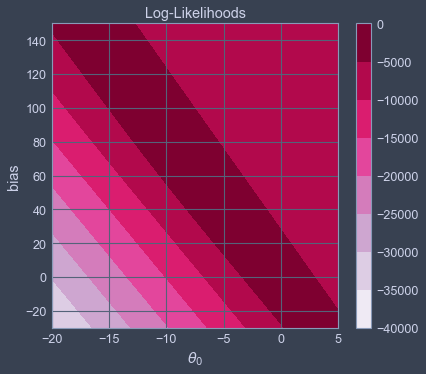

In [12]:
# Use only the width feature
width_features = binary_digits_features[:,0]
width_features_prime = add_one_features(width_features)
binary_digits_labels

# axis limits to plot
min_theta_0 = -20.0
max_theta_0 = 5.0
min_bias = -30.0
max_bias = 150.0

# resolution for both axis
N = 50
thetas_0 = np.linspace(min_theta_0, max_theta_0, N)
biases = np.linspace(min_bias, max_bias, N)

# 2D array with log likelihoods to be filled
log_likelihoods = np.zeros(shape=(len(biases), len(thetas_0)))
# fill the 2D array
for i_theta_0, theta_0 in enumerate(thetas_0):
    for i_bias, bias in enumerate(biases):
        # construct theta
        theta = np.array([theta_0, bias])
        h_x = hypothesis(width_features_prime, theta)
        ll = log_likelihood(h_x, binary_digits_labels)
        log_likelihoods[i_bias,i_theta_0] = ll

# plot log likelihoods
X, Y = np.meshgrid(thetas_0, biases)
cs = plt.contourf(X, Y, log_likelihoods, cmap="PuRd")
plt.title('Log-Likelihoods')
plt.xlabel(r'$\theta_0$')
plt.ylabel('bias')
plt.colorbar(cs)

plt.show()

### Maximizing log likelihood: Gradient Ascent

In the lectures you were introduced to gradient descent, a method to find the (local) minimum of a function.

$\q{4.4}$ Explain the intuition behind gradient descent in your own words or illustrate the concept.

Remember that we want to _maximize the log likelihood_. Therefore, we will reformulate the gradient descent algorithm and simply apply it in the opposite direction. This is what that looks like:
1. Set $\theta$ to a vector of random values.
2. For each training epoch:
    * Compute the gradient of the _log likelihood_ function for $\theta$ and training samples.
    * Adjust $\theta$ in the direction of the gradient using step size $\alpha$.
3. Repeat from step 2 until convergence or a set number of epochs.

$\q{4.5}$ Which of these steps has been reversed with regards to gradient descent?

For step 2, we will need the **gradient** of the _log likelihood_ function. We will provide this for you:

(eq. 4.6)$$
\frac{\partial}{\partial \theta_j} \ell(\theta) = (y - h_{\theta}(x))x_j
$$

$\q{4.6 (optional)}$ Validate this derivative by computing the derivative of $\ell(\theta)$ yourself. 
__Hint: remember the useful property of the logistic function? Also remember the chain rule.__

In step 2, we adjust $\theta$ in the direction of the gradient multiplied by the learning rate $\alpha$. We are going to write this adjustment for each separate parameter of $\theta$; $\theta_j$:

(eq. 4.7)$$
\theta_j := \theta_j + \alpha \frac{\partial}{\partial \theta_j} \ell(\theta)\\
\theta_j := \theta_j + \alpha(y^{(i)} - h_{\theta}(x^{(i)}))x_j^{(i)}
$$
where $\alpha$ is the learning rate and $x_j^{(i)}$ is the $j$-th feature of digit $i$.

$\q{4.7}$ Why do we need the learning rate?

$\ex{4.2}$ Implement the code to calculate and apply the gradient ascent step (eq. 4.7). Try doing this without writing explicit `for` loops. Use NumPy to make computations for the entire array of values at once. In addition, complete the function which returns an updated theta value.

In [13]:
def calculate_gradients(theta, x, y):
    """
    Calculate the gradient for every datapoint in x
    :param theta: numpy array of theta
    :param x: numpy array of the features
    :param y: the label (positive (1) or negative (0))
    :return: The gradients for every datapoint in x
    """
    gradients = np.zeros((len(x), len(theta)))
    # START ANSWER
    for i in range(len(x)):
        gradients[i] = (y[i] - hypothesis(x, theta)[i]) * x[i]
    # END ANSWER
    return gradients

theta = np.array([1,1.5,2.5])
x = np.array([[-10,5,1],[0.5,1,1]])
y = np.array([0,1])
gradients = calculate_gradients(theta, x, y)
print(gradients)

assert np.isclose(gradients[0], np.array([5.0, -2.5, -0.5])).all()
assert np.isclose(gradients[1], np.array([0.00549347, 0.01098694, 0.01098694]), atol= 0.0001).all()

[[ 5.         -2.5        -0.5       ]
 [ 0.00549347  0.01098694  0.01098694]]


In [14]:
def apply_gradient(theta, gradient, alpha):
    """
    Applies the gradient step to theta and returns an adjusted theta.
    :param theta: current theta array of size (d,)
    :param x: feature array of size (d,)
    :param alpha: learning rate
    :return: the updated theta array of size (d,)
    """
    updated_theta = theta.astype('float')
    # START ANSWER
    for i in range(len(theta)):
        updated_theta[i] = theta[i] + alpha * gradient[i]
    # END ANSWER
    return updated_theta

theta = np.array([1,2,3])
gradient = np.array([10,-10,5])
alpha = 0.1
updated_theta = apply_gradient(theta, gradient, alpha)
print(updated_theta)

assert (updated_theta == np.array([2,1,3.5])).all()

[2.  1.  3.5]


Let's now use the functions we just defined to train the classifier to obtain appropriate values for $\theta$ by maximizing the log likelihood.

$\ex{4.3}$ Complete the code below to run your classifier and obtain the $\theta$ vector.

In [17]:
def train_theta(features, labels, n_epochs=200, theta=None, alpha = 0.1):
    assert len(features) == len(labels)

    num_features = len(features[0])
    num_items = len(features)
    # Set theta to intial random values
    # Initialize theta randomly if it's not provided
    if theta is None:
        theta = np.random.normal(0, .05, num_features)

    # We go through the entire training set a number of times
    # Each of these iterations is called an epoch
    for epoch in range(n_epochs):
        # calculate the average gradient for all items and apply gradient ascent to theta
        # START ANSWER
        gradients = calculate_gradients(theta, features, labels)
        theta = apply_gradient(theta, np.sum(gradients, axis=0)/num_items, alpha)
        # END ANSWER
    
    return theta


# train a theta vector for the features and labels of the binary digits:
theta = train_theta(binary_digits_features_prime, binary_digits_labels, n_epochs=200, alpha = 0.1)

print("theta vector:  " + str(theta))
print("log likelihood: " + str(log_likelihood(hypothesis(binary_digits_features_prime, theta),binary_digits_labels)))

theta vector:  [-3.44957923  1.80616464 -0.21260538]
log likelihood: -561.5933310971252


Now we have obtained a trained theta vector, let's plot the decision boundary in the 2D scatterplot.

$\q{4.8}$ Why does this plot the decision boundary? Make sure that you understand the code. 

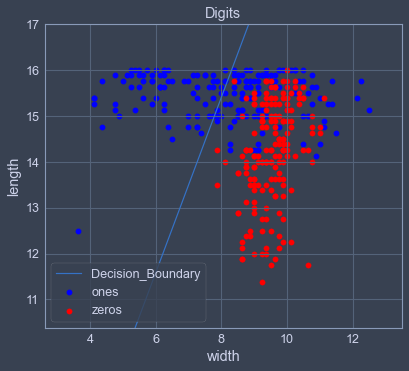

In [46]:
def decision_boundary(theta, plot_x):
    return (-1/theta[1]) * (theta[0] * plot_x + theta[2])

def plot_decision_boundary(theta, data, labels):
    db_x = np.array([data[:,0].min()-1, data[:,0].max()+1])# we don't want the points in the dataset as start and end points
    db_y = decision_boundary(theta, db_x)
    plot_scatter(data, labels, db_x = db_x, db_y = db_y)

plot_decision_boundary(theta, binary_digits_features_prime, binary_digits_labels)

Look at the decision bounday in the plot above. Does it roughly separate the two classes? Please check your implementation if it doesn't (or if you don't see the decision boundary at all). If we can optimize our logistic classifier to obtain a decision boundary for these 2 features we can continue to now use the digits pixels as features.

## 5. Logistic Regression on MNIST pixel data
Great! We now have implemented logistic regression to separate two classes based on 2 features. Let's extend this implementation to use a different representation of the object: the intensities of the 64 pixels!

Run the code below to initialize the data.

In [17]:
from sklearn.model_selection import train_test_split

#flatten de data so all items are 1D and append an extra one feature to every item
binary_digits_pixels = add_one_features(binary_digits_images.reshape(binary_digits_images.shape[0], -1))

# the shape should be (360, 65)
print(binary_digits_pixels.shape)

# Split dataset into train and test set
x_train_digits, x_test_digits, y_train_digits, y_test_digits = train_test_split(binary_digits_pixels, binary_digits_labels, test_size=0.3)

(360, 65)


Let's obtain a theta vector which can classify the binary digits with our previous implemented train function

In [18]:
# train a theta vector for the features and labels of the binary digits:
theta_digits = train_theta(x_train_digits, y_train_digits)
print("theta vector: " + str(theta_digits))

theta vector: [-0.01675225  0.03387811  0.00953068 -0.21838403 -0.09142355  0.27299303
  0.09278001 -0.0172994   0.02545178  0.00291415 -0.40563084 -0.03895479
  0.17696149 -0.11905819  0.0297737   0.01358816 -0.01569036 -0.1176243
 -0.30538014  0.44109533  0.61887558 -0.27145239 -0.07316051  0.04664973
 -0.06095092 -0.17191385 -0.17206552  0.62242132  0.71893211 -0.16193354
 -0.35822691 -0.00139283  0.00301586 -0.13897627 -0.33480375  0.56280466
  0.73202643 -0.04128426 -0.32196439  0.0345107  -0.07100379 -0.16744491
 -0.52634435  0.45925083  0.68473608 -0.23926845 -0.28201572  0.06598853
 -0.00460739 -0.0438611  -0.48175967  0.03996495  0.18464236 -0.13305967
  0.06547289  0.04966025 -0.02761749  0.02977399 -0.15957217 -0.30068615
 -0.01247844  0.25212973  0.21643799  0.11157285 -0.03824587]


Let's assess how well this theta can classifiy the digits. First, we want to be able to make predictions for a test set. Before you write any code, think about how you can transform a continuous probability into a discrete label.

$\ex{5.1}$ Write a predict function that gives the predictions for an entire test set.

In [19]:
def predict_binary(x_test, theta):
    """
    Predicts a label for each image in x_test using theta.
    :param x_test: an array of size (n, 65) of all test images.
    :param theta: a (65,) array of trained theta.
    :return: an integer array of size (n,) of labels for each test_image.
    """
    predictions = np.zeros(x_test.shape[0], dtype=int)
    # START ANSWER
    predictions = hypothesis(x_test, theta)
    predictions = np.where(predictions > 0.5, 1, 0)
    # END ANSWER
    return predictions

x_test = np.array([[1,2,3,1], [-1,2,1.5,1], [4,-5,2,4]])
theta = np.array([1,-1,2,-2])
predictions = predict_binary(x_test, theta)
print(predictions)

assert (predictions == np.array([1, 0, 1])).all()
assert predictions.dtype == np.dtype('int')

[1 0 1]


Given a set of predictions, we would like to compute the accuracy of these predictions.

$\ex{5.2}$ Complete the `accuracy` function, which returns the percentage of predictions that were correct.

In [20]:
def compute_accuracy(predictions, y_true):
    """
    Computes the accuracy of the predictions based on the true labels.
    :param predictions: an array of size (n,) of the computed predictions for each image.
    :param y_true: an array of size (n,) of the true labels of each image.
    :return: the accuracy of the predictions.
    """
    accuracy = -1
    # START ANSWER
    accuracy = len(np.where(predictions == y_true)[0])/predictions.shape[0]
    # END ANSWER
    return accuracy

predictions = np.array([0,1,1,0,1])
y_true = np.array([0,1,0,1,1])

accuracy = compute_accuracy(predictions, y_true)
assert accuracy == 0.6

Let's now assert the quality of our binary classifier with the newly implemented functions on the test data

In [21]:
predictions = predict_binary(x_test_digits, theta_digits)
accuracy = compute_accuracy(predictions, y_test_digits)

print("accuracy: " + str(accuracy))
assert accuracy > 0.95

accuracy: 1.0


With the pixel features we are able to obtain quite a good $\theta$ to create an accurate classifier. You can visualise the $\theta$ vector with the code below.

(65,)

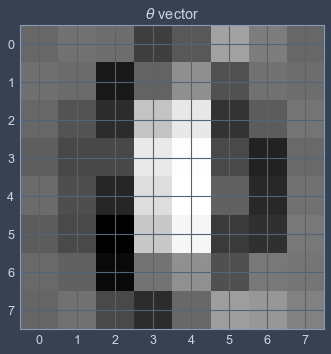

In [22]:
def plot_theta_image(theta, title=r"$\theta$ vector"):
    # remove bias from the image
    theta_no_bias = theta[:64].reshape(8,8)
    plt.figure()
    plt.gray()
    plt.title(title)
    plt.imshow(theta_no_bias)

plot_theta_image(theta_digits)
theta_digits.shape

$\q{5.1}$ Try to interpret the image. Can you explain why the $\theta$ vector is shaped like the image you see?

### Learning curves

$\ex{5.3}$ Complete the following code to see how the classifier develops over time. Plot both the accuracy and the log likelihood over time for the train dataset.

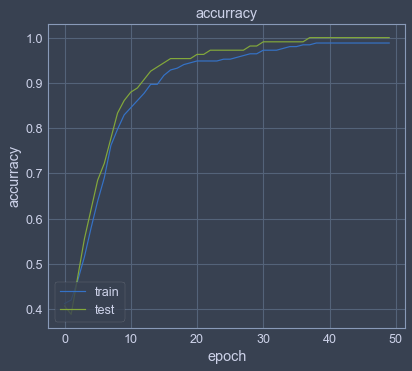

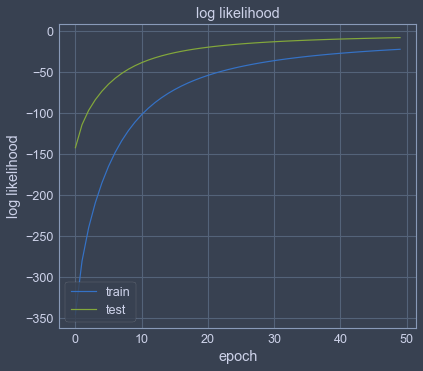

In [23]:
# Set learning rate (try experimenting with this)
alpha = 0.001

# Set theta to intial value of None
theta_digits = None

# We go through the entire training set a number of times
# Each of these iterations is called an epoch
n_epochs = 50

accuracies_train = []
accuracies_test = []
log_likelihoods_train = []
log_likelihoods_test = []

for epoch in range(n_epochs):
    theta_digits = train_theta(x_train_digits, y_train_digits, n_epochs=1, theta=theta_digits, alpha = alpha)
    #calculate accuracy
    accuracy_train = -1
    accuracy_test = -1
    # START ANSWER
    accuracy_train = [compute_accuracy(predict_binary(x_train_digits, theta_digits), y_train_digits)]
    accuracy_test = [compute_accuracy(predict_binary(x_test_digits, theta_digits), y_test_digits)]
    # END ANSWER
    accuracies_train.append(accuracy_train)
    accuracies_test.append(accuracy_test)
    
    # calculate log likelihood
    ll_train = 0
    ll_test = 0
    # START ANSWER
    ll_train = [log_likelihood(hypothesis(x_train_digits, theta_digits), y_train_digits)]
    ll_test = [log_likelihood(hypothesis(x_test_digits, theta_digits), y_test_digits)]
    # END ANSWER
    log_likelihoods_train.append(ll_train)
    log_likelihoods_test.append(ll_test)
        
plt.plot(np.arange(len(accuracies_train)), accuracies_train, label='train')
plt.plot(np.arange(len(accuracies_test)), accuracies_test, label='test')
plt.title('accurracy')
plt.xlabel('epoch')
plt.ylabel('accurracy')
plt.legend(loc=3)
plt.show()

plt.plot(np.arange(len(log_likelihoods_train)), log_likelihoods_train, label='train')
plt.plot(np.arange(len(log_likelihoods_test)), log_likelihoods_test, label='test')
plt.title('log likelihood')
plt.xlabel('epoch')
plt.ylabel('log likelihood')
plt.legend(loc=3)
plt.show()

$\q{5.2}$ You can see that both curves are different. Can you explain the differences?

Try setting the learning rate to a higher value and a lower value (e.g.: 0.001, 0.005, 0.0001 respectively).

$\q{5.3}$ Experiment with the learning rate. What is the effect on the 'learning curve'? Which learning rate performs better? Why?

## 6. Multi-class Logistic Classifier

Next, we will extend your code for binary classification to a multiclass classification for all 10 classes.
First load the data with the code below

In [24]:
# Import the load function for the dataset
from sklearn import datasets
from sklearn.model_selection import train_test_split

n_classes = 10

# Load the digits with 10 classes (digits 0 - 9)
all_digits = datasets.load_digits(n_class=n_classes)
all_digits_images = all_digits.images
all_digits_labels = all_digits.target

#flatten de data so they are 1D and append extra ones to the feature vectors
all_digits_pixels = add_one_features(all_digits_images.reshape(all_digits_images.shape[0], -1))

# the shape should be (1797, 65)
print(all_digits_pixels.shape)

# Split dataset into train and test set
x_train_digits, x_test_digits, y_train_digits, y_test_digits = train_test_split(all_digits_pixels, all_digits_labels, test_size=0.3)

(1797, 65)


$\q{6.1}$ Before we go through the steps to turn our binary classifier into a multiclass classifier, think about how you would do this yourself.

The strategy we will be using to construct a multiclass classifier from a binary classifier is know as "one-vs-all", or "one-vs-rest". The idea is to construct separate binary classifiers for each class that discriminate between that class and all other classes. We then combine the predictions of the resulting ten classifiers. While this is a general strategy that works for many types of classifiers, note that for logistic regression specifically, there are other (more principled) ways to construct a multiclass classifier, that we will not consider here. 

Remember that earlier we set the hypothesis function to give the probability that an image was a $1$.

$$
P(Y = 1 | x; \theta) = h_{\theta}(x)\\
P(Y \neq 1 | x; \theta) = P(Y = 0 | x; \theta) = 1 - h_{\theta}(x)
$$

Because the only other class was $0$, we could conclude that an image was $0$ if the probability was low. However, now we have 9 other classes, so we can only conclude that the digit is one of the 9 other classes in case $P(y = 1 | x; \theta)$ is low.


$\ex{6.1}$ We will create ten hypothesis functions (ten different theta's $\theta_i$): one for each class. Each hypothesis tells us the probability that a given image belongs to the corresponding class of $\theta_i$. If the probability is low, it must belong to some other class.

In [27]:
# initialize a theta array, one for every class
multiclass_thetas = np.zeros((10,65))

for class_no in range(n_classes):
    current_label = class_no
    # Hint: convert the labels array to have only 1's at the current class_no
    # START ANSWER
    multiclass_thetas[class_no] = train_theta(x_train_digits, 
                                              np.where(y_train_digits == current_label, 1, 0), 
                                              n_epochs=50, theta=None, alpha = 0.01)
    # END ANSWER
    print("class_no: " + str(class_no))

print("first 3 parameters of every theta")
print(multiclass_thetas[:,:3])

class_no: 0
class_no: 1
class_no: 2
class_no: 3
class_no: 4
class_no: 5
class_no: 6
class_no: 7
class_no: 8
class_no: 9
first 3 parameters of every theta
[[ 0.00834246 -0.04311743  0.08975093]
 [-0.00112757  0.04584268 -0.10985877]
 [-0.01608915  0.00434594  0.03387072]
 [ 0.02283565 -0.0559026   0.05059915]
 [ 0.09566628 -0.03297182 -0.05169196]
 [ 0.06710293 -0.00123944  0.05654719]
 [-0.02828342  0.03475715 -0.1153536 ]
 [ 0.05542192  0.01100003  0.00140077]
 [ 0.05112295 -0.06974263 -0.06150431]
 [ 0.0272031  -0.06480726 -0.04724438]]


Now that we have obtained the theta values, let's see how well it predicts the class labels.
When we apply these ten hypothesis functions to an image, we get ten different probabilities.

$\q{6.2}$ Given ten probabilities, one for each class, how would you decide which class an image belongs to?

$\ex{6.2}$ Finish the predict function for ten classes.

__Hint:__ `np.argmax` can be used to return the index of the maximum value in an array.

In [28]:
def predict_multiclass(x_test, theta):
    """
    Predicts a label for each image in x_test using theta.
    :param x_test: an array of size (n, 65) of all test images.
    :param theta: an (10,65) array of trained thetas.
    :return: an array of size (n,) of labels for each test_image.
    """
    predictions = np.zeros(x_test.shape[0], dtype=int)
    for i, x in enumerate(x_test):
        # START ANSWER
        predictions[i] = np.argmax([np.dot(x, theta[j]) for j in range(theta.shape[0])])
        # END ANSWER
    return predictions

predictions = predict_multiclass(x_train_digits, multiclass_thetas)
# And print the accuracy
accuracy = compute_accuracy(predictions, y_train_digits)
print("accuracy: " + str(accuracy))

assert accuracy > 0.9

accuracy: 0.94351630867144


We can again plot the thetas for every class. Try again to see if they make sense.

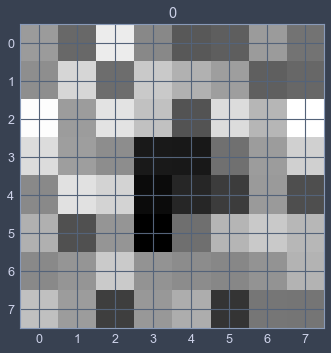

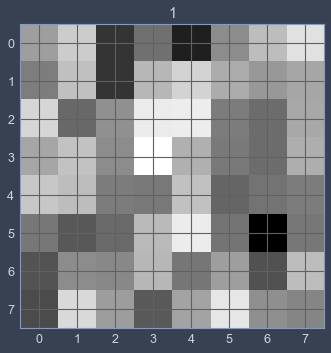

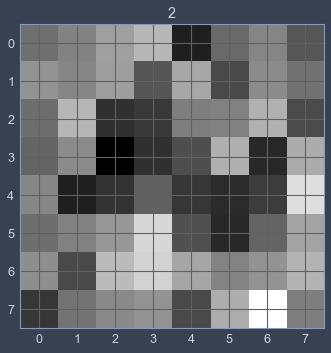

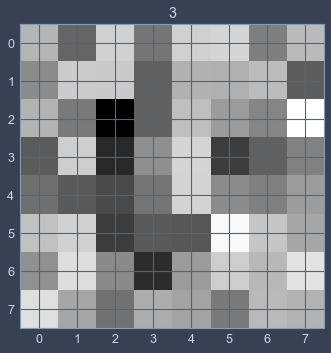

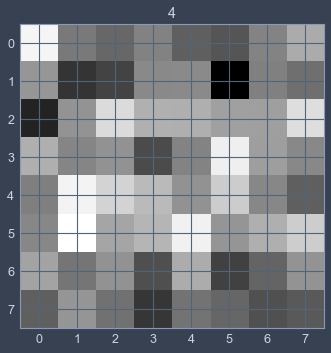

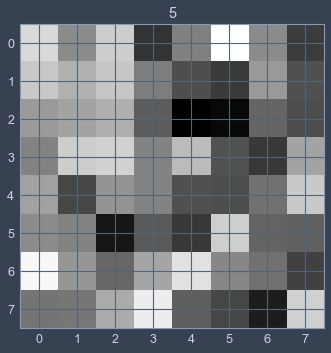

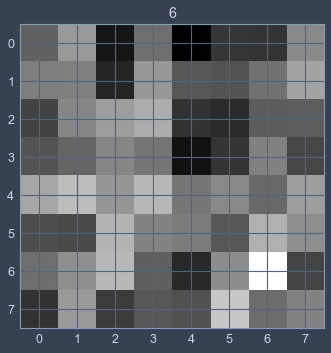

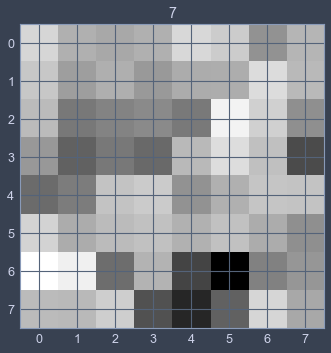

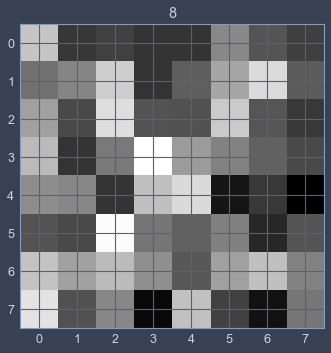

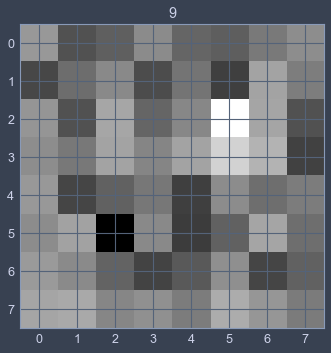

In [29]:
for i in range(n_classes):
    plot_theta_image(multiclass_thetas[i], str(i))

## 7. Bias-Variance Tradeoff Analysis

In the previous week, you have implemented K-Nearest Neighbours, which is a non-parametric, non-linear classifier. In this assignment, you implemented a linear classifier. Let's see how they compare in terms of bias and variance.

- Bias describes how far the average classifier (averaged over datasets) deviates from the true values. Models with high bias have low attention to the training data and are prone to oversimplification (underfitting).
- Variance describes how much the predictions change when the training set changes. Models with high variance have a high attention to the training data and are prone to overfitting.

Often, a classifier with high bias has a low variance and vice-versa. Both high bias and high variance cause high errors on the test data and ideally you want to have them both low. However, you cannot have them both low at the same time. Finding a balance between bias and variance to minimize the generalization error is what is known as the bias-variance trade-off. 

$\q{7.1}$ Which classifier do you expect to have higher bias: K-NN or the Logistic Classifier?

$\q{7.2}$ Which classifier do you expect to have higher variance: K-NN or the Logistic Classifier?

To give you an intuition about these concepts, without going into too much detail, we will investigate these two with `scikit-learn`'s implementation. We will plot the decision boundaries in a 2D plot of the crescent moons dataset, also known as the "bananas" dataset.

D:\Programmer\Anaconda\lib\site-packages\ipykernel_launcher.py:57: UserWarning: No contour levels were found within the data range.
D:\Programmer\Anaconda\lib\site-packages\ipykernel_launcher.py:57: UserWarning: No contour levels were found within the data range.
D:\Programmer\Anaconda\lib\site-packages\ipykernel_launcher.py:57: UserWarning: No contour levels were found within the data range.
D:\Programmer\Anaconda\lib\site-packages\ipykernel_launcher.py:57: UserWarning: No contour levels were found within the data range.
D:\Programmer\Anaconda\lib\site-packages\ipykernel_launcher.py:57: UserWarning: No contour levels were found within the data range.
D:\Programmer\Anaconda\lib\site-packages\ipykernel_launcher.py:57: UserWarning: No contour levels were found within the data range.
D:\Programmer\Anaconda\lib\site-packages\ipykernel_launcher.py:57: UserWarning: No contour levels were found within the data range.
D:\Programmer\Anaconda\lib\site-packages\ipykernel_launcher.py:57: UserWarni

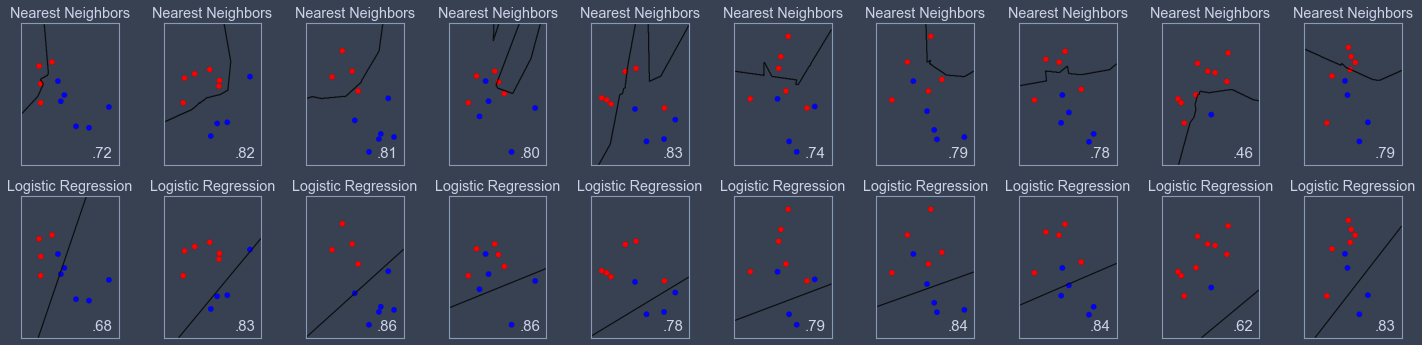

In [30]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import time

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(multi_class='multinomial', solver='lbfgs')]

x7, y7 = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
x7 += 2 * rng.uniform(size=x7.shape)
linearly_separable = (x7, y7)

ds = make_moons(100, noise=0.3, random_state=0,)
figure = plt.figure(figsize=(20, 5))
i = 1
n_iterations = 10
for iteration in range(n_iterations):
    # preprocess dataset, split into training and test part
    x7, y7 = ds
    x7 = StandardScaler().fit_transform(x7)
    x7_train, x7_test, y7_train, y7_test = train_test_split(x7, y7, test_size=.9, random_state=int(time.perf_counter()) + iteration)

    x7_min, x7_max = x7[:, 0].min() - .5, x7[:, 0].max() + .5
    y7_min, y7_max = x7[:, 1].min() - .5, x7[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x7_min, x7_max, h), np.arange(y7_min, y7_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    # iterate over classifiers
    c = 0
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(classifiers), n_iterations, i+c*n_iterations)
        clf.fit(x7_train, y7_train)
        score = clf.score(x7_test, y7_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]-0.5

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contour(xx, yy, Z, alpha=.8, levels=[0.5])

        # Plot the training points
        ax.scatter(x7_train[:, 0], x7_train[:, 1], c=y7_train, cmap=cm_bright,
                   edgecolors='k')

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        c+=1
    i += 1

plt.tight_layout()
plt.show()

$\q{7.3}$ How can you tell which classifier has higher bias? What about the variance? Do the results in these figures correspond to your answer in 7.1 and 7.2?

The bias error is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).

The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting).

$\q{7.4}$ When would you prefer a classifier with high bias and low variance? When would you prefer a classifier with low bias and high variance?